In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout, Bidirectional

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Amazon.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,520.556302,526.216132,514.277282,520.429832,520.429832,7.329010e+06
std,857.161696,865.821041,847.270905,856.668492,856.668492,7.149521e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.750000,39.514999,38.104999,38.821251,38.821251,3.579350e+06
50%,92.669998,94.190002,90.750000,92.639999,92.639999,5.470000e+06
75%,528.949982,535.304993,521.950012,529.450012,529.450012,8.294950e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6155 entries, 0 to 6154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6155 non-null   object 
 1   Open       6155 non-null   float64
 2   High       6155 non-null   float64
 3   Low        6155 non-null   float64
 4   Close      6155 non-null   float64
 5   Adj Close  6155 non-null   float64
 6   Volume     6155 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 336.7+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.750196,0.749933,0.750572,0.750367,0.750367,-0.412482
Open,0.750196,1.000000,0.999934,0.999912,0.999842,0.999842,-0.240087
High,0.749933,0.999934,1.000000,0.999893,0.999924,0.999924,-0.238907
Low,0.750572,0.999912,0.999893,1.000000,0.999928,0.999928,-0.241351
Close,0.750367,0.999842,0.999924,0.999928,1.000000,1.000000,-0.240122
Adj Close,0.750367,0.999842,0.999924,0.999928,1.000000,1.000000,-0.240122
Volume,-0.412482,-0.240087,-0.238907,-0.241351,-0.240122,-0.240122,1.000000


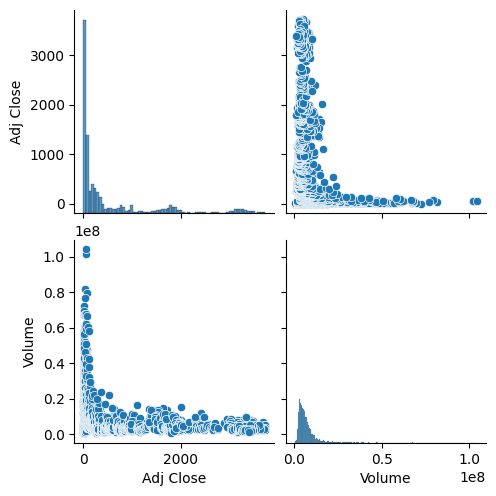

In [ ]:
df_selected = df[['Adj Close', 'Volume']]

pairplot = sns.pairplot(df_selected)

plt.show()

In [ ]:
df = df.drop(['Close'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])

In [80]:
features = df[['Open', 'High', 'Volume', 'Low']]
target = df['Adj Close']

In [81]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [82]:
X = np.array(features_scaled)
y = np.array(target)


In [ ]:
prices = df['Adj Close'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [ ]:
time_step = 60

In [ ]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # Extract time_step values
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Corresponding label
    return np.array(X), np.array(Y)

X, y = create_dataset(scaled_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(units=50))
model.add(Dense(units=1))


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.99)

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop, model_checkpoint, lr_scheduler])

Epoch 1/5
122/122 [==============================] - 56s 270ms/step - loss: 0.0243 - val_loss: 0.0099 - lr: 9.9000e-05
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 34s 276ms/step - loss: 0.0125 - val_loss: 0.0095 - lr: 9.8010e-05
Epoch 3/5
122/122 [==============================] - 41s 336ms/step - loss: 0.0112 - val_loss: 0.0081 - lr: 9.7030e-05
Epoch 4/5
122/122 [==============================] - 31s 256ms/step - loss: 0.0104 - val_loss: 0.0058 - lr: 9.6060e-05
Epoch 5/5
122/122 [==============================] - 31s 259ms/step - loss: 0.0099 - val_loss: 0.0055 - lr: 9.5099e-05


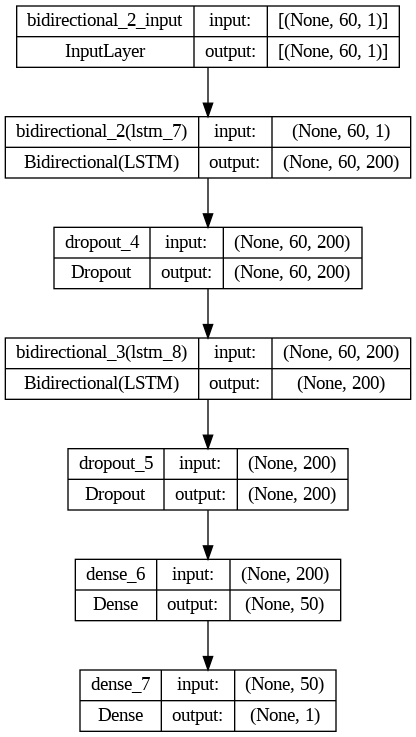

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
mse = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mse}')

39/39 [==============================] - 6s 102ms/step
Root Mean Squared Error: 955.5985429635735
Mean Absolute Error: 493.9046008016836
